In [67]:
from nd2helper import ND2Stack
import pickle
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import os
from PIL import Image
import matplotlib as mpl
from matplotlib.patches import Circle
from matplotlib.text import Text
mpl.rcParams['figure.dpi'] = 150
plt.rcParams['image.cmap'] = 'gray'

from collections import namedtuple


In [68]:
# declare helper functions

def show_images(imglist,labels=None):
    n_imgs = len(imglist)
    fig,ax = plt.subplots(1,n_imgs)
    for i in range(n_imgs)     :
        ax[i].imshow(imglist[i],cmap='gray')
        if labels:
            ax[i].set_title(str(labels[i]))
def show_countours(img,contours=[],labels=None):
    n_imgs = len(contours)
    fig,ax = plt.subplots(1,n_imgs+1)
    ax[0].imshow(img)
    ax[0].set_title('image')
    for i in range(n_imgs):
        ax[i+1].imshow(img,cmap='gray')
        ax[i+1].contour(contours[i], [0.5], linewidths=1.2, colors='r')
        if labels:
            ax[i+1].set_title(str(labels[i]))
            
def convert(img, target_type_min, target_type_max, target_type):
    imin = img.min()
    imax = img.max()

    a = (target_type_max - target_type_min) / (imax - imin)
    b = target_type_max - a * imax
    new_img = (a * img + b).astype(target_type)
    return new_img

def remove_outside_extrema(l, min, max):
    ll = list(l)
    ol = []
    for i in range(len(ll)):
        if ll[i] >= min and ll[i] <= max:
            ol.append(ll[i])
    return ol

In [129]:
# define some variables
datfile = "../galvano_003_10series_analysis-s08.pkl"
with open(datfile,"rb") as infile:
    data = pickle.load(infile)
data.keys()
nd2file = os.path.join(data['directory'],data['filename'])
stack = ND2Stack(nd2file)
bbox = list(map(int, data['background_box']))
used_channel = 2
blur_radius = 3
used_frame = data['nonempty_frames'][0]
print("Used frame", used_frame)

Used frame 6


In [130]:
# load data and convert to suitable formats
series = stack.get_series(data['series_idx'])
frame = series[used_frame]
channels16bit = list(map(lambda f: Image.fromarray(f.astype(np.uint16)), frame))
arrays16bit = np.array(list(map(lambda c: np.array(c), channels16bit)))
arrays8bit = np.array(list(map(lambda a: convert(a,0,255,np.uint8), arrays16bit)))
channels8bit = list(map(lambda a: Image.fromarray(a), arrays8bit))

In [131]:
# import necessary skimage libraries
from skimage import color
from skimage.transform import hough_circle, hough_circle_peaks
from skimage.feature import canny
from skimage.draw import circle_perimeter
from skimage.util import img_as_ubyte,img_as_uint
from skimage.filters import gaussian
from skimage.measure import find_contours,approximate_polygon,regionprops,label
from scipy import ndimage as ndi
from skimage.color import label2rgb

Using channel 2 : Alexa Fluor 647 R-phycoerythrin streptavidin/pH 7.2


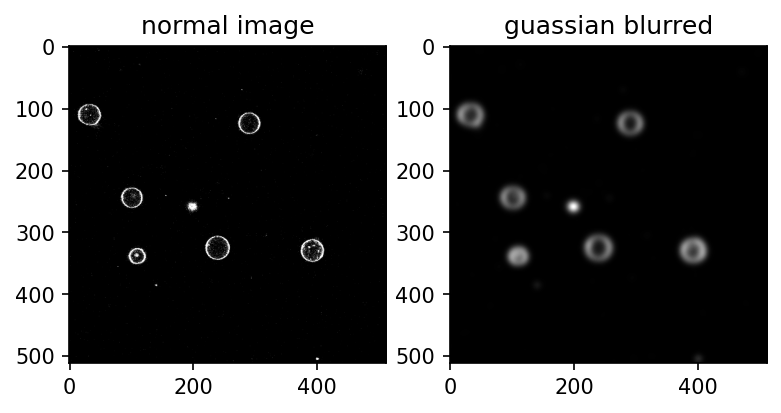

In [132]:
# img = img_as_ubyte(gaussian(arrays16bit[0],sigma=5))
img = img_as_ubyte((arrays8bit[used_channel]))
img_blur = img_as_ubyte(gaussian(img_as_ubyte(arrays8bit[used_channel].copy()),sigma=5.))
print("Using channel",used_channel,":", stack.stack.metadata['channels'][used_channel])
show_images([img,img_blur],labels=["normal image","guassian blurred"])

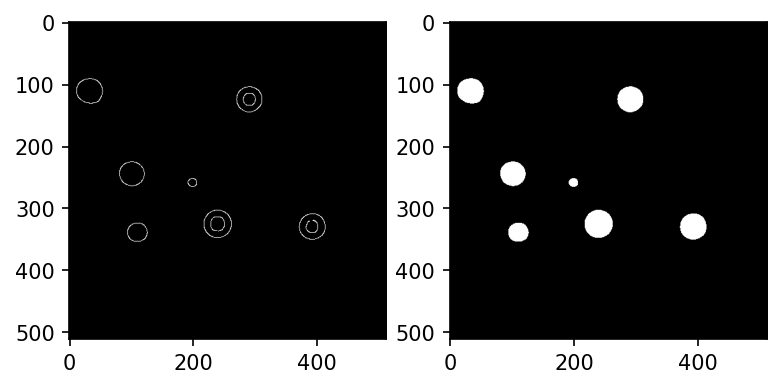

In [133]:
edges = canny(img, sigma=5, low_threshold=20, high_threshold=50)
filled = ndi.binary_fill_holes(edges)
show_images([edges,filled])

found 7 GUVs with average radius 18.514800 px (7.805043 ± 2.08 um)


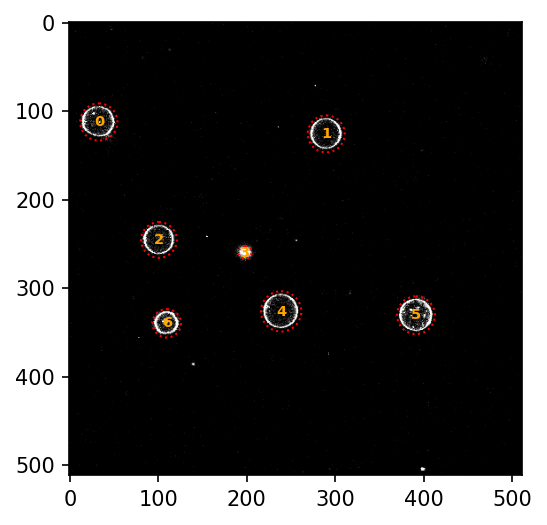

In [134]:
labels = label(filled)
fig,ax = plt.subplots(1,1)
# ax.imshow(label2rgb(labels))
ax.imshow(img)
points = []
diams = []
for p in regionprops(labels):
    points.append(p.centroid)
    diams.append(.5*(p.minor_axis_length + p.major_axis_length))
y,x = zip(*points)
r = .5*np.array(diams)
for i in range(len(diams)):
    ax.add_artist(Circle(xy=(x[i],y[i]),radius=r[i],edgecolor='r',ls=':',fill=False))
    ax.annotate(i, (x[i],y[i]),color='orange', weight='bold', fontsize=7, ha='center', va='center')
print("found %d GUVs with average radius %lf px (%lf ± %.02f um)" 
      % (len(diams),r.mean(),r.mean()*stack.pixelsize,r.std()*stack.pixelsize))
plt.savefig("sample.png",dpi=300)

In [135]:
guv_data = []
# idx = 4
margin = 7
# for idx in [0,1]:
for idx in range(len(diams)):
    center = {'x': int(x[idx]),'y': int(y[idx])}
    radius = int(r[idx])+margin
    upper,left,lower,right = (center['y']-radius,center['x']-radius,center['y']+radius,center['x']+radius)
#     print((left,upper,right,lower))
    intensities = {}
    f_idc = remove_outside_extrema(l=range(used_frame-4,used_frame+5), min=0, max=10)
    max_frame = (0,0) # frameidx,intensity
    filled = {}
    for f in f_idc:
        curframe = convert(img_as_ubyte(series[f][used_channel].astype(np.uint16)),0,255,np.uint8)
        im1 = Image.fromarray(curframe)
        im1 = im1.crop((left,upper,right,lower))
        cropped = np.array(im1)
        blur = img_as_ubyte(gaussian(cropped,sigma=blur_radius))
        edges = canny(cropped, sigma=blur_radius, low_threshold=20, high_threshold=50)
        filled[f] = img_as_ubyte(ndi.binary_fill_holes(edges))
    #     print(np.array(im1).dtype)
        intensities[f] = filled[f].sum()
        if intensities[f] > max_frame[1]:
            max_frame = (f,intensities[f])
#         print(f"Frame {f} has summed intensity: {intensities[f]}")
    #     plt.figure()
        lbls = 3*["frame %d" %f]
#         show_images([im1,blur,filled],lbls)
    if max_frame[0] == used_frame:
        cur_diam = diams[idx]
    else:
        regions = regionprops(label(filled[max_frame[0]]))
        cur_diam = .5*(regions[0].minor_axis_length + regions[0].major_axis_length)
    guv_data.append({'frame': max_frame[0], 'x': center['x'], 'y': center['y'], 'radius': round(.5*cur_diam,3)})
    print(f"Frame {used_frame} was selected by user for GUV {idx}")
    print("Maximum intensity found in frame %d with intensity %d" % max_frame)
    print("This is %.02f%% higher than the intensity of the selected frame" % ((max_frame[1] - intensities[used_frame])/intensities[used_frame]*100))
print(guv_data)

Frame 6 was selected by user for GUV 0
Maximum intensity found in frame 7 with intensity 322575
This is 1.44% higher than the intensity of the selected frame
Frame 6 was selected by user for GUV 1
Maximum intensity found in frame 7 with intensity 313395
This is 0.99% higher than the intensity of the selected frame
Frame 6 was selected by user for GUV 2
Maximum intensity found in frame 6 with intensity 290700
This is 0.00% higher than the intensity of the selected frame
Frame 6 was selected by user for GUV 3
Maximum intensity found in frame 3 with intensity 75735
This is 107.69% higher than the intensity of the selected frame
Frame 6 was selected by user for GUV 4
Maximum intensity found in frame 8 with intensity 383775
This is 2.59% higher than the intensity of the selected frame
Frame 6 was selected by user for GUV 5
Maximum intensity found in frame 7 with intensity 340935
This is 3.16% higher than the intensity of the selected frame
Frame 6 was selected by user for GUV 6
Maximum inte

In [136]:
guv_per_frame = {}
for idx in range(len(diams)):
    frame = guv_data[idx]['frame']
    if frame in guv_per_frame:
        guv_per_frame[frame].append(guv_data[idx])
    else:
        guv_per_frame[frame] = [guv_data[idx]]
    print("Radius difference: %.03f µm" % (np.abs(r[idx]-guv_data[idx]['radius'])*stack.pixelsize))

Radius difference: 0.408 µm
Radius difference: 0.478 µm
Radius difference: 0.000 µm
Radius difference: 0.990 µm
Radius difference: 0.359 µm
Radius difference: 0.289 µm
Radius difference: 0.265 µm


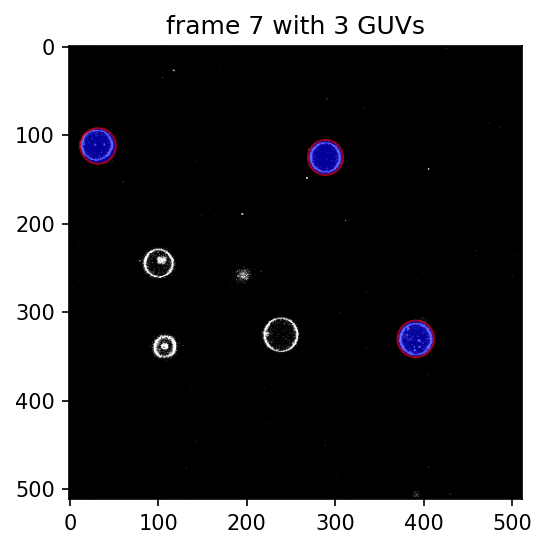

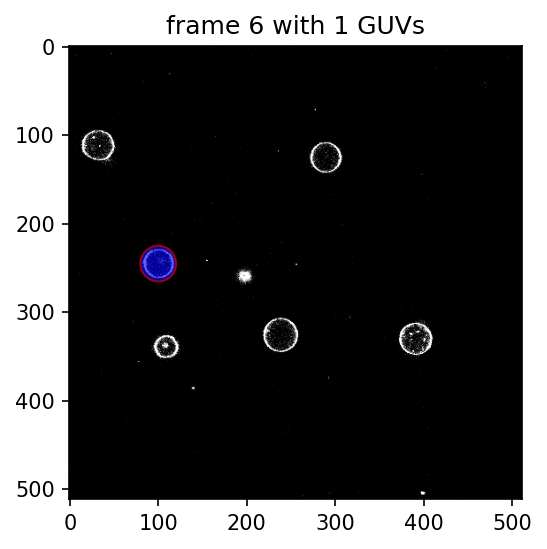

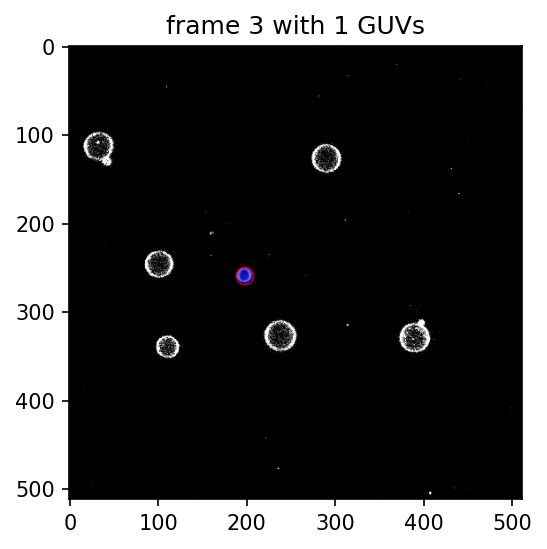

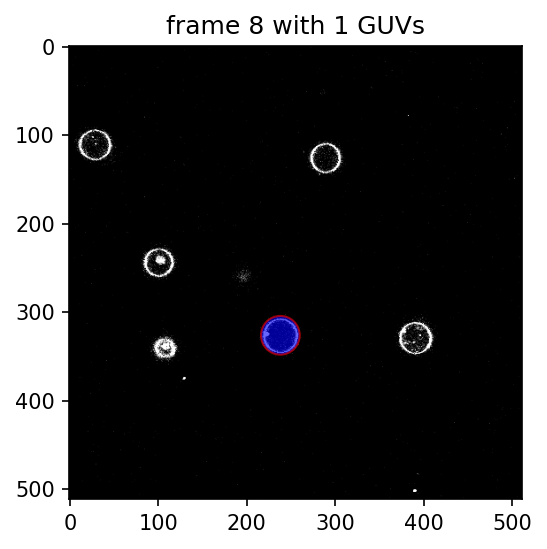

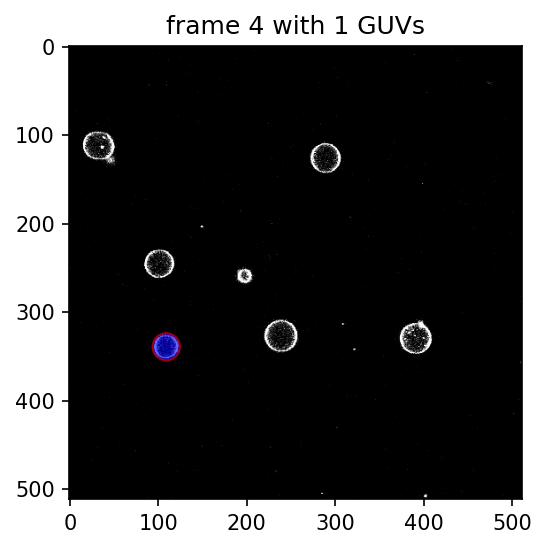

In [138]:
for f,guvs in guv_per_frame.items():
    fig,ax = plt.subplots(1,1)
    ax.imshow(convert(img_as_ubyte(series[f][used_channel].astype(np.uint16)),0,255,np.uint8))
    ax.set_title(f"frame {f} with {len(guvs)} GUVs")
    for guv in guvs:
        ax.add_artist(Circle(xy=(guv['x'],guv['y']),radius=guv['radius'],edgecolor='r',ls='-',facecolor='b',alpha=.6))
#         ax.annotate(i, (guv['x'],guv['y']),color='orange', weight='bold', fontsize=7, ha='center', va='center')
    plt.savefig(f"results_f{f}.png")

# Pseudocode for finding GUVs
```python
current_frame = x # found by user selection
margin = 5 # add extra 5px for selection of the GUV
GUVs = label(frames[current_frame])
for g in GUVs:
    center = g.center
    radius = g.radius+margin
    upper,left,lower,right = (center.x-radius,center.y-radius,center.y+radius,center.x+radius)
    frame_range = range(current_frame-3,current_frame+3)
    intensities = {}
    for f in frame_range:
        img = frames[f].crop(upper,left,lower,right)
        intensities[f] = calc_intensity(img)
    
```

## Some old code

In [8]:
# Detect two radii
hough_radii = np.arange(15, 50, 2)
hough_res = hough_circle(edges, hough_radii)

# Select the most prominent 3 circles
accums, cx, cy, radii = hough_circle_peaks(hough_res, hough_radii)

In [9]:
print(radii)

[19 15 15 ... 45 45 45]


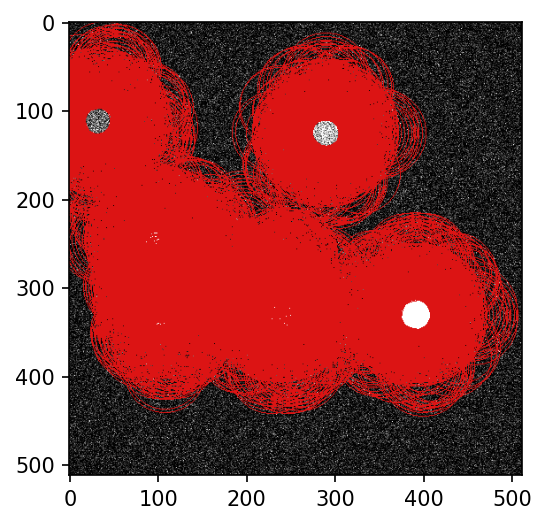

In [10]:
# Draw them
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(10, 4))
image = color.gray2rgb(img)
for center_y, center_x, radius in zip(cy, cx, radii):
    circy, circx = circle_perimeter(center_y, center_x, radius,
                                    shape=image.shape)
    image[circy, circx] = (220, 20, 20)

ax.imshow(image, cmap=plt.cm.gray)
plt.show()

num contours found: 7


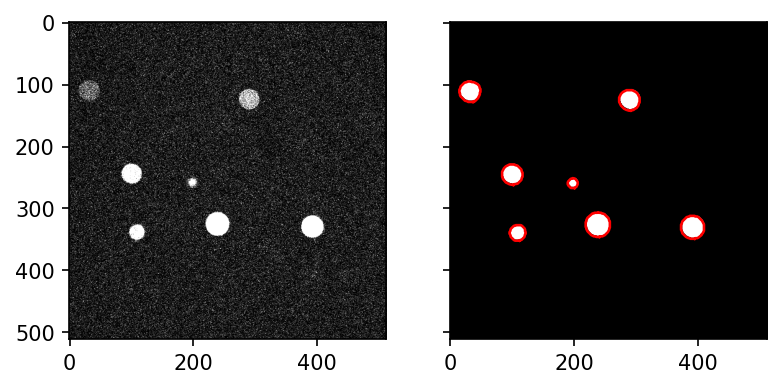

In [11]:
contours = find_contours(filled,0)
print("num contours found:",len(contours))
fig,ax = plt.subplots(1,2,sharey=True,sharex=True)
ax[0].imshow(img)
for contour in contours:
    coords = approximate_polygon(contour, tolerance=.5)
    ax[1].imshow(filled)
    ax[1].plot(coords[:, 1], coords[:, 0], '-r', linewidth=1.25)